# Machine Learning and Content Analytics

> Konstantinos Ninas, f2822108 <br />
> Stamatios Sideris, f2822113 <br />
> Yiannis Vaniotis, f2822101 <br />
> Orestis Loukopoulos, f2822104 <br />

> MSc in Business Analytics <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />

In [82]:
#import libraries
import pandas as pd
import numpy as np
import sklearn
from simpletransformers.seq2seq import Seq2SeqModel,Seq2SeqArgs
from fastai.text.all import *
from transformers import AutoConfig 
import textwrap
from sklearn.pipeline import Pipeline
from tensorflow.python.keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import word_tokenize
from statistics import mode
import pickle as pickle
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Concatenate, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.layers import recurrent
from keras import backend as K 
from rouge import Rouge

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In this module we develop and train a custom article summarization model.

In [83]:
#read the csv file
mydata = pd.read_csv('/content/initial_dataset.csv', engine = 'python', error_bad_lines = False)

#drop the column 'Unnamed: 0'
mydata = mydata.drop('Unnamed: 0', axis = 1)

mydata

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 403: field larger than field limit (131072)
Skipping line 1264: field larger than field limit (131072)
Skipping line 1335: field larger than field limit (131072)
Skipping line 1367: field larger than field limit (131072)


Publication_Number  \
0      US-2014213605-A1   
1         US-7828769-B2   
2      US-2006106306-A1   
3      US-2012172955-A1   
4      US-2010119601-A1   
...                 ...   
2846       US-5894757-A   
2847       US-5056550-A   
2848      US-7266558-B2   
2849       US-5722134-A   
2850       US-5106699-A   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Description  \
0     the present invention relates to methods for treating eye disorders using opioid receptor antagonists . the aspects , uses , and advantages for such methods and treatment indications , according to the present invention , may be better understood with reference to the accompanying description . the description is not to be taken in a limiting sense , but is made merely for the purpose of illustrating the general principles of the invention , since the scope of the present invention is best defined by the appended claims . exemplary embodiments of the present invention are detailed below in...   
1     fig1 is a cross - sectional diagram of a manual / auto - prime air elimination system 100 according to one embodiment of the invention . the manual / auto - prime air elimination system 100 includes a drip chamber 102 , an inlet 105 , an outlet 106 , an automatic air eliminator 120 , and a mechanical air eliminator 150 . the drip chamber 102 may contain fluid 110 and air 112 . the manual / auto - prime air elimination system 100 vents air 112 from the drip chamber 102 , as it is imperative that the air 112 not travel into the outlet 106 . the automatic air eliminator 120 includes a body 12...   
2     certain molecular markers can be used as indicators of the status of the sentinel lymph node . for example , cytokine and chemokine gene expression in melanoma sentinel lymph nodes ( sln ) varies with disease stage , i . e ., whether cancer cells are present in the snl or not . the pattern of inflammatory cytokines can be used to determine the presence of cancer in these lymph nodes . for example , the expression of molecular markers interleukin - 13 ( il - 13 ), indoleamine 2 , 3 - dioxygenase ( ido ), interferon gamma ( ifn ), and interleukin - 10 ( il - 10 ) increases , and interleukin ...   
3     various embodiments of the present invention are described hereinafter with reference to the figures . it should be noted that the figures are not drawn to scale and elements of similar structures or functions are represented by like reference numerals throughout the figures . it should also be noted that the figures are only intended to facilitate the description of specific embodiments of the invention . in addition , an aspect described in conjunction with a particular embodiment of the present invention is not necessarily limited to that embodiment and can be practiced in any other emb...   
4     this invention relates to a pharmaceutical composition for sublingual or buccal administration of a hormone having low to poor aqueous solubility , such as melatonin . for purposes of the subject invention , the description refers to melatonin as the active pharmaceutical ingredient ( api ), or drug , but would be understood by persons having ordinary skill in the art to include other hormones which have low to poor water solubility in aqueous environment or in aqueous biological fluids such as saliva or gastrointestinal fluids . the invention further relates to a method of manufacture for...   
...                       

In this section we clean the data, by removing any duplicates and missing values (if they exist), convert all texts to lower case and replace any contractions

In [84]:
#drop the duplicate and na values from the records
mydata.drop_duplicates(subset=['Description'],inplace=True)
mydata.dropna(axis=0,inplace=True)

#We create one variable that will hold 
input = mydata.loc[:,'Description']
target = mydata.loc[:,'Summary']

In [167]:
#we create empty lists that will hold the cleaned articles
input_texts=[]
target_texts=[]
input_words=[]
target_words=[]

In [168]:
#we assign a file in a variable, which is in the form of a dictionary
#it contains contractions, for example (don't: do not)
all_contractions = pickle.load(open('contractions.pkl', 'rb'))['contractions']

In [169]:
#We create a function that will process and clean the data
def clean_text_data(texts):
  #tokenize the text into words, and convert them to lower cases
  cleaned_words=word_tokenize(texts.lower())

  #contraction file to expand shortened words
  cleaned_words= [all_contractions[w] if w in all_contractions else w for w in cleaned_words ]
  
  #return cleaned text
  return cleaned_words

In [170]:
#pass the input records and target records to recreate all texts in a cleaned format
for in_txt,tr_txt in zip(input,target):
  in_words= clean_text_data(in_txt)
  #we append each cleaned text sequence of tokens in the input_texts list
  input_texts+= [' '.join(in_words)]
  input_words+= in_words
  #add '<START>' at start and '<END>' at end of text
  tr_words= clean_text_data("textstart "+tr_txt+" textend")
  #we append each cleaned text sequence of tokens in the target_texts list
  target_texts+= [' '.join(tr_words)]
  target_words+= tr_words

In [171]:
#store only unique words from input and target list of words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))

In this section we split the data to train and test. We also initialize two tokenizers and fit them on our data. We also pad and truncate the converted sequences of tokens to ensure they all have the same length, so we can input them in our model.

In [172]:
#we split the initial dataset into train and test with 80/20 segments respectively
x_train,x_test,y_train,y_test=train_test_split(input_texts,target_texts,test_size=0.2,random_state=17) 

In [173]:
#We initiate two tokenizers - one for x_train and one for y_train
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(x_train)
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(y_train)
 
#convert all texts into sequences of ids from the tokenizer
x_train= input_tokenizer.texts_to_sequences(x_train) 
y_train= target_tokenizer.texts_to_sequences(y_train)

In [92]:
#we find the maximum length of the sequences of the target summaries
max_summ_len = mode([len(i) for i in target_texts])

In [95]:
#we pad with 0s the sequences of x_train and y_train in order to ensure that they all have the same length
#x_train sequences are padded up to 4000 numbers, because that is the maximum input the model can receive
en_in_data= pad_sequences(x_train,  maxlen=4000, padding='post') 
dec_data= pad_sequences(y_train,  maxlen=max_summ_len, padding='post')
 
#we remove the last word from the targets (<END>)
dec_in_data = dec_data[:,:-1]
#we reshape target data
dec_tr_data = dec_data.reshape(len(dec_data),max_summ_len,1)[:,1:]


In [96]:
#since some input data have lengths greater than 4000 columns, we truncate them to ensure they all have the same length
#we create an empty array with the right dimensions
truncated_in_data = np.empty(shape = (len(en_in_data), 4000), dtype=np.int32)
#we iteratively fill it with the truncated sequences of numbers
for i in range(len(en_in_data)):
  truncated_in_data[i] = en_in_data[i][:4000]

truncated_in_data

array([[  59,  221,    3, ...,    0,    0,    0],
       [   1,   45,   33, ...,    0,    0,    0],
       [   1,  173,   10, ...,    0,    0,    0],
       ...,
       [ 160,   47,  422, ...,    0,    0,    0],
       [  77,   14,  207, ...,    0,    0,    0],
       [   5, 2074, 1593, ...,    0,    0,    0]], dtype=int32)

In this section we set up the building and training configurations for our model. Also, we create its structure from scratch and we fit it on our data.

In [97]:
#we create a class that stores the configurations for the training and building of the model
class Config:
    """
    Configuration variables used for the model build and model fit.
    """
    RNN = recurrent.LSTM
    EMBED_HIDDEN_SIZE = 200
    BATCH_SIZE = 25
    EPOCHS = 20

In [98]:
#We create a clear session
K.clear_session() 
 
#create an input object that will be able to store the maximum length of inputs
en_inputs = Input(shape=(4000,)) 
#we create an embedding layer 
en_embedding = Embedding(len(input_words)+1, Config.EMBED_HIDDEN_SIZE)(en_inputs) 

In [99]:
#create 3 stacked LSTM layers with the shape of the hidden embedding layers
#LSTM 1
en_lstm1= LSTM(Config.EMBED_HIDDEN_SIZE , return_state=True, return_sequences=True) 
en_outputs1, state_h1, state_c1= en_lstm1(en_embedding) 
 
#LSTM2
en_lstm2= LSTM(Config.EMBED_HIDDEN_SIZE , return_state=True, return_sequences=True) 
en_outputs2, state_h2, state_c2= en_lstm2(en_outputs1) 
 
#LSTM3
en_lstm3= LSTM(Config.EMBED_HIDDEN_SIZE ,return_sequences=True,return_state=True)
en_outputs3 , state_h3 , state_c3= en_lstm3(en_outputs2)
 
#we assign the last encoder states in a new variable
en_states= [state_h3, state_c3]

In [100]:
# We create an input object for the decoder with no initial shape
dec_inputs = Input(shape=(None,)) 
#We create an embedding layer
dec_emb_layer = Embedding(len(target_words)+1, Config.EMBED_HIDDEN_SIZE) 
dec_embedding = dec_emb_layer(dec_inputs) 
 
#We create an LSTM layer in the decoder with the last output states of the encoder
dec_lstm = LSTM(Config.EMBED_HIDDEN_SIZE, return_sequences=True, return_state=True)
dec_outputs, *_ = dec_lstm(dec_embedding,initial_state=en_states) 

In [101]:
#We initialize an attention layer and use the decoder and the encoder outputs as inputs
attention =Attention()
attn_out = attention([dec_outputs,en_outputs3])
 
#Concatenate the attention output with the decoder outputs
merge=Concatenate(axis=-1, name='concat_layer1')([dec_outputs,attn_out])

In [102]:
#We create a dense layer
dec_dense = Dense(len(target_words)+1, activation='softmax') 
dec_outputs = dec_dense(merge) 

In [103]:
#Model class and model summary for text Summarizer
model = Model([en_inputs, dec_inputs], dec_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4000)]       0           []                               
                                                                                                  
 tf.cast (TFOpLambda)           (None, 4000)         0           ['input_1[0][0]']                
                                                                                                  
 tf.compat.v1.nn.embedding_look  (None, 4000, 200)   0           ['tf.cast[0][0]']                
 up (TFOpLambda)                                                                                  
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                           

In [104]:
#We compile the model, set the optimizer, the loss function and the metric to evaluate the training
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 

In [105]:
#we train the model
history = model.fit( 
    [truncated_in_data, dec_in_data],
    dec_tr_data, 
    batch_size=25, 
    epochs=Config.EPOCHS, 
    validation_split=0.2
    )

Epoch 1/20
73/73 [==============================] - 70s 877ms/step - loss: 6.7641 - accuracy: 0.8175 - val_loss: 6.4969 - val_accuracy: 0.8376
Epoch 2/20
73/73 [==============================] - 62s 856ms/step - loss: 6.5637 - accuracy: 0.8289 - val_loss: 6.5036 - val_accuracy: 0.8376
Epoch 3/20
73/73 [==============================] - 63s 859ms/step - loss: 6.5043 - accuracy: 0.8289 - val_loss: 6.4562 - val_accuracy: 0.8376
Epoch 4/20
73/73 [==============================] - 63s 859ms/step - loss: 6.4840 - accuracy: 0.8289 - val_loss: 6.4503 - val_accuracy: 0.8376
Epoch 5/20
73/73 [==============================] - 62s 856ms/step - loss: 6.4786 - accuracy: 0.8289 - val_loss: 6.4470 - val_accuracy: 0.8376
Epoch 6/20
73/73 [==============================] - 63s 861ms/step - loss: 6.4888 - accuracy: 0.8362 - val_loss: 6.4526 - val_accuracy: 0.8507
Epoch 7/20
73/73 [==============================] - 62s 856ms/step - loss: 6.4850 - accuracy: 0.8434 - val_loss: 6.4418 - val_accuracy: 0.8505

Text(0, 0.5, 'Loss')

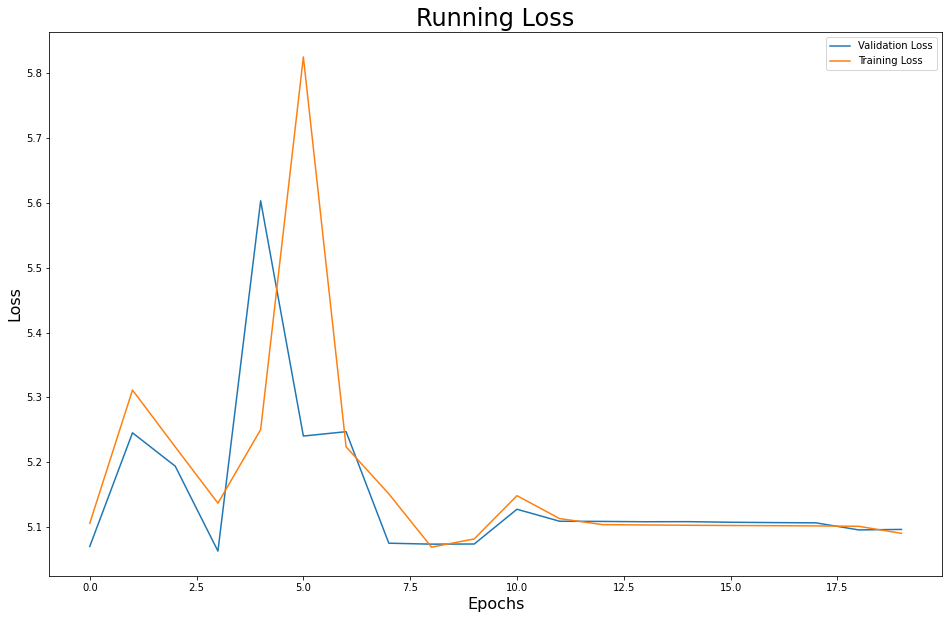

In [90]:
#We plot the running loss from the training
plt.figure(figsize=(16,10))
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Running Loss", fontsize = 24)
plt.legend(("Validation Loss", "Training Loss"))
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)

In [ ]:
#Save model's weights
model.save_weights("ckpt")

In [ ]:
model.load_weights("ckpt")

NotFoundError: ignored

We create an encoder and a decoder model from the above model and use it to create a pipeline that will predict the summaries of any text given as input

In [112]:
# We create an encoder inference model to conduct predictions on new data
 
#We store the final LSTM output layer and the final states of the above model
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]
#We use the encoder output and the states to create an encoding model
en_model = Model(model.input[0],[en_outputs]+en_states)

In [113]:
# We create an decoder inference model to conduct predictions on new data
#create Input object for hidden and cell state for decoder
#shape of layer with hidden or latent dimension
dec_state_input_h = Input(shape=(Config.EMBED_HIDDEN_SIZE,))
dec_state_input_c = Input(shape=(Config.EMBED_HIDDEN_SIZE,))
dec_hidden_state_input = Input(shape=(4000,Config.EMBED_HIDDEN_SIZE))
 
#we use the input and initialize the decoder lstm layer with the last states of encoder
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_embedding, initial_state=[dec_state_input_h,dec_state_input_c])

In [114]:
#We call the attention layer and input the decoder's output and the newly created hidden state
attn_out2 = attention([dec_outputs2,dec_hidden_state_input])

#we merge the decoder outputs with the new attention layer
merge2 = Concatenate(axis=-1)([dec_outputs2, attn_out2])

In [115]:
#We use the merged layer as input to the dense layer
dec_outputs2 = dec_dense(merge2)
 
#We define a new model using the decoder inputs, the decoder's last states and the decoder's outputs 
dec_model = Model(
[dec_inputs] + [dec_hidden_state_input,dec_state_input_h,dec_state_input_c],
[dec_outputs2] + [state_h2, state_c2])

We predict the summaries for all the articles in our dataset and evaluate them with the human-written ones using the rouge metric.

In [174]:
#We create a dictionary with the indexes and the words from each tokenizer 
reverse_target_word_index = target_tokenizer.index_word
reverse_source_word_index = input_tokenizer.index_word
#we create a dictionary with  a word-index structure from the target tokenizer
target_word_index = target_tokenizer.word_index
#we set the key 0 of the index-word target dictionary to blank ' '
reverse_target_word_index[0]=' '
 

10

In [181]:
#We create a function that will decode and predict the summary of an input text
def summary_prediction(input_seq):
    #get the encoder output and states by passing the input sequence
    en_out, en_h, en_c= en_model.predict(input_seq)
 
    #target sequence starting with 'textstart'
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_word_index['textstart']
 
    #if the iteration reaches the end of text than it will be stop the iteration
    break_condition = False
    #append every predicted word in decoded sentence
    decoded_sentence = ""
    while not break_condition: 
        #get predicted output, hidden and cell state.
        output_words, dec_h, dec_c= dec_model.predict([target_seq] + [en_out,en_h, en_c])
        
        #get the index and from the dictionary get the word for that index.
        word_index = np.argmax(output_words[0, -1, :])
        text_word = reverse_source_word_index[word_index]
        decoded_sentence += text_word +" "
        # Exit condition: either hit max length
        # or find a stop word or last word.
        if text_word == "textend" or len(decoded_sentence) > 150:
          break_condition = True
        #update target sequence to the current word index.
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    #return the decoded sentence
    return decoded_sentence

In [176]:
#We create a function that will process the data and convert them to a number sequence form
def tokenizer_text(input):
  inp_review = clean_text_data(input)
  inp_review = ' '.join(inp_review)
  inp_x= input_tokenizer.texts_to_sequences([inp_review]) 
  inp_x= pad_sequences(inp_x,  maxlen=4000, padding='post')

  truncated_input = np.empty(shape = (1, 4000), dtype=np.int32)
  truncated_input[0] = inp_x[0][:4000]
  return truncated_input

In [185]:
#We create a new column that will store the predicted summaries from the custom model
mydata['Predicted_Summaries'] = 'None'

In [194]:
#We iterate once for every observation
for i in range(len(mydata)):
  #We vectorize the input
  truncated_input = tokenizer_text(mydata.loc[i, 'Description'])

  #We predict the summary
  mydata.loc[i, 'Predicted_Summaries']=summary_prediction(truncated_input.reshape(1,4000))
  #if there is the textend token in the predicted summary we remove it
  if 'textend' in mydata.loc[i, 'Predicted_Summaries'] :
    mydata.loc[i, 'Predicted_Summaries']=mydata.loc[i, 'Predicted_Summaries'].replace('<END>','')

In [195]:
#We initialize a rouge object
R = Rouge()
#We calculate the rouge scores for the predictions vs the actual summaries
R.get_scores(mydata.loc[:,'Predicted_Summaries'], mydata.loc[:,'Summary'], avg=True)

{'rouge-1': {'r': 0.00016769094425013123,
  'p': 0.0015783935461241667,
  'f': 0.0002982306917797268},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.00016769094425013123,
  'p': 0.0015783935461241667,
  'f': 0.0002982306917797268}}